In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, f1_score, precision_score, recall_score)
from sklearn.utils.class_weight import compute_class_weight
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
print("=== Fraud Detection: Decision Tree Classifier ===")
print("=" * 50)

# STEP 1: Load and Prepare Data
print("\n1. Loading and preparing data...")

# Load the cleaned data
df = pd.read_csv('data/processed/cc_cleaned.csv')
print(f"Dataset shape: {df.shape}")

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Select only numerical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numerical_features]

print(f"Using {len(numerical_features)} numerical features")
print(f"Class distribution: {y.value_counts().to_dict()}")

=== Fraud Detection: Decision Tree Classifier ===

1. Loading and preparing data...
Dataset shape: (281918, 34)
Using 32 numerical features
Class distribution: {0: 281470, 1: 448}


In [3]:
# STEP 2: Train-Test Split
print("\n2. Performing stratified train-test split...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")



2. Performing stratified train-test split...
Training set: (225534, 32)
Test set: (56384, 32)
Training fraud rate: 0.0016
Test fraud rate: 0.0016


In [4]:
# STEP 3: Handle Class Imbalance
print("\n3. Handling class imbalance...")

# Calculate class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))

print(f"Class weights: {class_weight_dict}")
print(f"Fraud weight is {class_weight_dict[1]/class_weight_dict[0]:.1f}x higher than legitimate weight")



3. Handling class imbalance...
Class weights: {np.int64(0): np.float64(0.5007949337407184), np.int64(1): np.float64(314.99162011173183)}
Fraud weight is 629.0x higher than legitimate weight


In [5]:
# STEP 4: Hyperparameter Tuning
print("\n4. Tuning Decision Tree hyperparameters...")

# Initial Decision Tree
base_dt = DecisionTreeClassifier(
    class_weight=class_weight_dict,
    random_state=42
)

# Parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Use GridSearchCV for hyperparameter tuning
print("Performing grid search...")
grid_search = GridSearchCV(
    base_dt, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Hyperparameter tuning completed")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score (ROC-AUC): {grid_search.best_score_:.4f}")



4. Tuning Decision Tree hyperparameters...
Performing grid search...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Hyperparameter tuning completed
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score (ROC-AUC): 0.9477


In [6]:
# STEP 5: Train Final Decision Tree
print("\n5. Training final Decision Tree model...")

# Train with best parameters
best_dt = grid_search.best_estimator_
best_dt.fit(X_train, y_train)

print("✓ Model training completed")



5. Training final Decision Tree model...
✓ Model training completed


In [7]:
# STEP 6: Make Predictions
print("\n6. Making predictions...")

# Get probability scores
y_pred_proba = best_dt.predict_proba(X_test)[:, 1]  # Probability of fraud

# Predict with default threshold (0.5)
y_pred = best_dt.predict(X_test)

print("Predictions generated")



6. Making predictions...
Predictions generated


In [8]:
# STEP 7: Evaluate Model Performance
print("\n7. Evaluating model performance...")

# Basic metrics with default threshold
print("\nPerformance with default threshold (0.5):")
print("=" * 40)

accuracy = best_dt.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Avg Precision: {avg_precision:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Legit', 'Actual Fraud'], 
                    columns=['Predicted Legit', 'Predicted Fraud'])
print(cm_df)



7. Evaluating model performance...

Performance with default threshold (0.5):
Accuracy:  0.9544
Precision: 0.0314
Recall:    0.9222
F1-Score:  0.0607
ROC-AUC:   0.9747
Avg Precision: 0.6142

Confusion Matrix:
              Predicted Legit  Predicted Fraud
Actual Legit            53731             2563
Actual Fraud                7               83


In [9]:
# STEP 8: Threshold Tuning for Fraud Detection
print("\n8. Threshold tuning analysis...")

# Try different thresholds
thresholds = np.arange(0.1, 0.9, 0.1)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    precision_t = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall_t = recall_score(y_test, y_pred_thresh)
    f1_t = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    results.append({
        'threshold': threshold,
        'precision': precision_t,
        'recall': recall_t,
        'f1_score': f1_t
    })

results_df = pd.DataFrame(results)
print("\nPerformance across different thresholds:")
print(results_df.round(4))

# Find optimal threshold based on F1-score
optimal_idx = results_df['f1_score'].idxmax()
optimal_threshold = results_df.loc[optimal_idx, 'threshold']
optimal_f1 = results_df.loc[optimal_idx, 'f1_score']

print(f"\nOptimal threshold: {optimal_threshold:.2f} (F1-score: {optimal_f1:.4f})")



8. Threshold tuning analysis...

Performance across different thresholds:
   threshold  precision  recall  f1_score
0        0.1     0.0036  0.9778    0.0071
1        0.2     0.0208  0.9333    0.0406
2        0.3     0.0208  0.9333    0.0406
3        0.4     0.0208  0.9333    0.0406
4        0.5     0.0314  0.9222    0.0607
5        0.6     0.0314  0.9222    0.0607
6        0.7     0.2273  0.8889    0.3620
7        0.8     0.2273  0.8889    0.3620

Optimal threshold: 0.70 (F1-score: 0.3620)


In [10]:
# STEP 9: Feature Importance Analysis
print("\n9. Feature importance analysis...")

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 most important features:")
print("=" * 40)
for i, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:15}: {row['importance']:.4f}")



9. Feature importance analysis...

Top 15 most important features:
V14            : 0.8203
V4             : 0.0771
V10            : 0.0557
V12            : 0.0469
V3             : 0.0000
Time           : 0.0000
V2             : 0.0000
V1             : 0.0000
V7             : 0.0000
V6             : 0.0000
V5             : 0.0000
V8             : 0.0000
V11            : 0.0000
V9             : 0.0000
V13            : 0.0000



10. Creating performance visualizations...


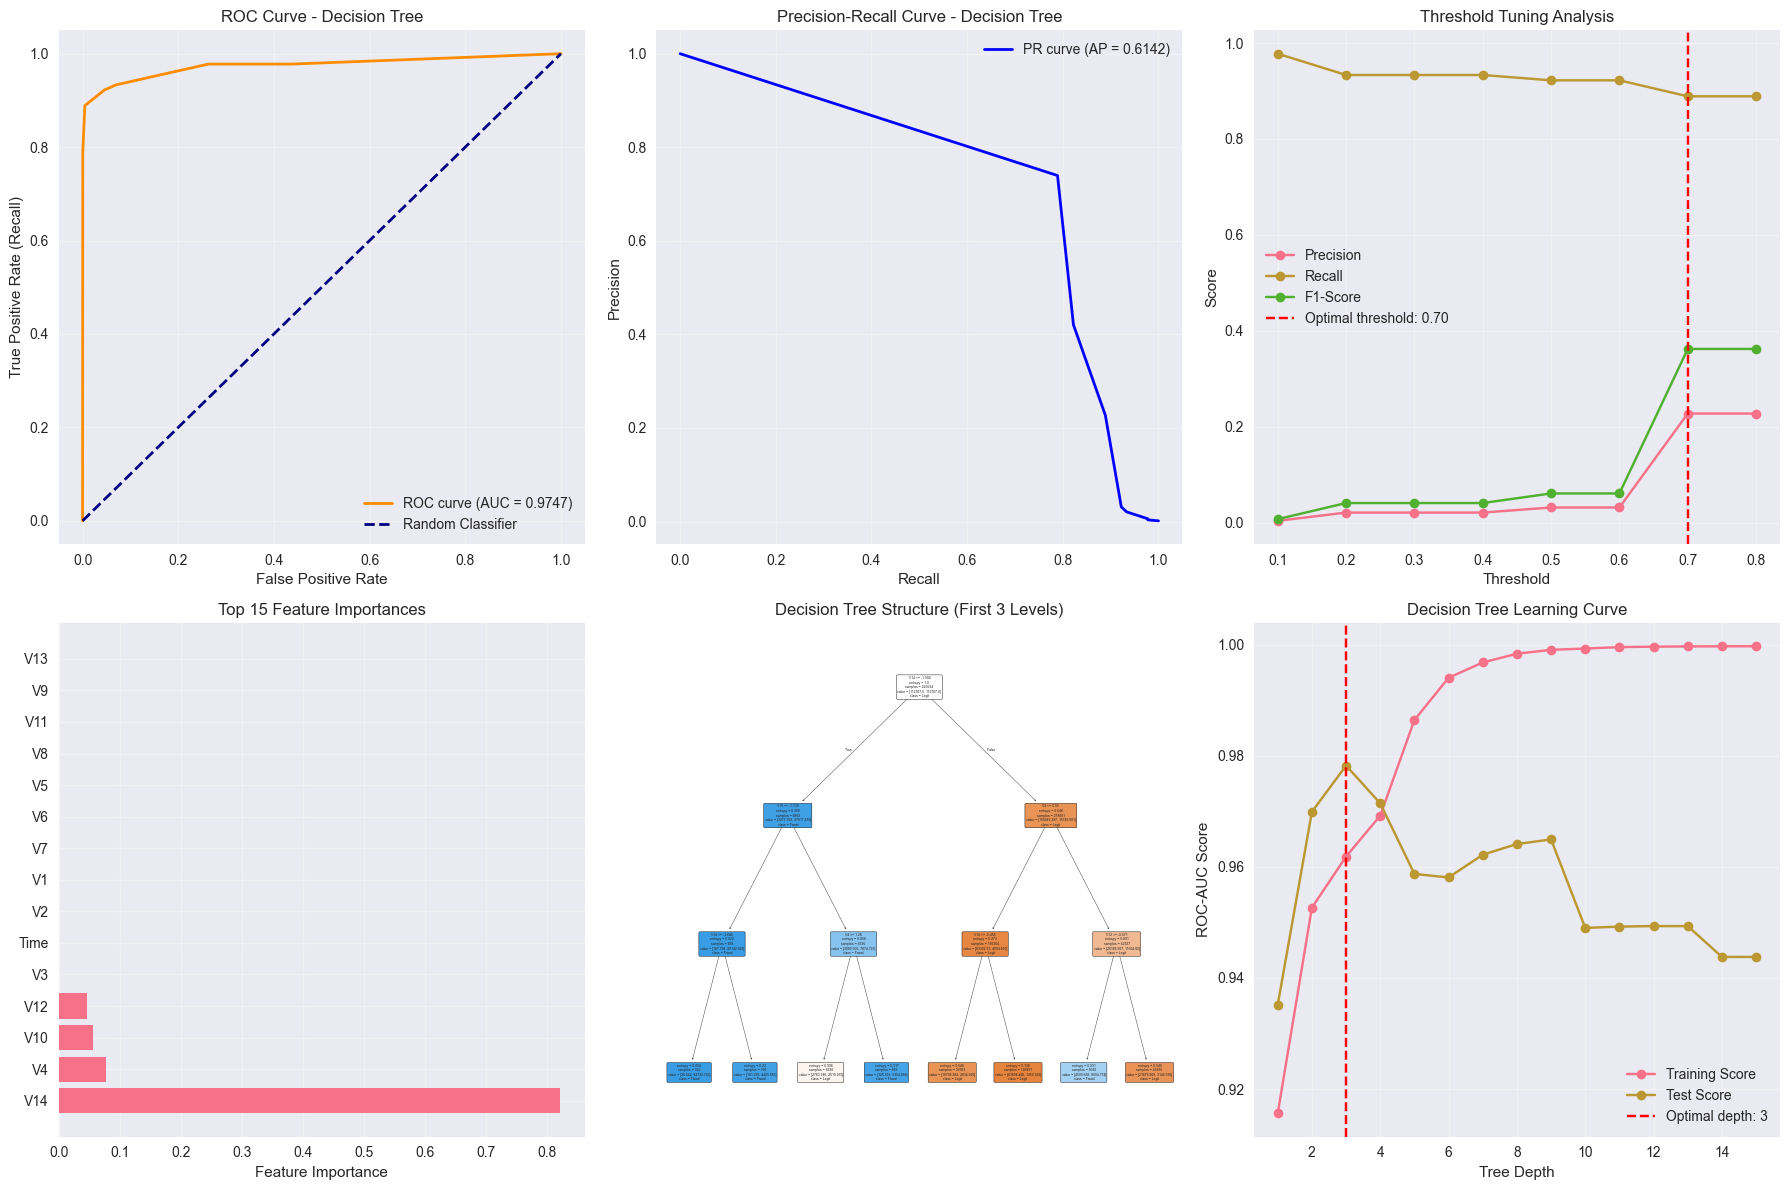

In [11]:
# STEP 10: Visualization
print("\n10. Creating performance visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate (Recall)')
axes[0,0].set_title('ROC Curve - Decision Tree')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Precision-Recall Curve
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
axes[0,1].plot(recall_vals, precision_vals, color='blue', lw=2, 
               label=f'PR curve (AP = {avg_precision:.4f})')
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curve - Decision Tree')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Threshold Analysis
axes[0,2].plot(results_df['threshold'], results_df['precision'], 'o-', label='Precision')
axes[0,2].plot(results_df['threshold'], results_df['recall'], 'o-', label='Recall')
axes[0,2].plot(results_df['threshold'], results_df['f1_score'], 'o-', label='F1-Score')
axes[0,2].axvline(optimal_threshold, color='red', linestyle='--', 
                  label=f'Optimal threshold: {optimal_threshold:.2f}')
axes[0,2].set_xlabel('Threshold')
axes[0,2].set_ylabel('Score')
axes[0,2].set_title('Threshold Tuning Analysis')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Plot 4: Feature Importance
top_features = feature_importance.head(15)
axes[1,0].barh(range(len(top_features)), top_features['importance'])
axes[1,0].set_yticks(range(len(top_features)))
axes[1,0].set_yticklabels(top_features['feature'])
axes[1,0].set_xlabel('Feature Importance')
axes[1,0].set_title('Top 15 Feature Importances')
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Tree Visualization (first 3 levels)
plot_tree(best_dt, 
          feature_names=X.columns,
          class_names=['Legit', 'Fraud'],
          filled=True,
          rounded=True,
          max_depth=3,  # Show only first 3 levels for readability
          ax=axes[1,1])
axes[1,1].set_title('Decision Tree Structure (First 3 Levels)')

# Plot 6: Learning Curve (simplified)
train_scores = []
test_scores = []
depths = range(1, 16)

for depth in depths:
    dt_temp = DecisionTreeClassifier(
        max_depth=depth,
        class_weight=class_weight_dict,
        random_state=42
    )
    dt_temp.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train, dt_temp.predict_proba(X_train)[:, 1]))
    test_scores.append(roc_auc_score(y_test, dt_temp.predict_proba(X_test)[:, 1]))

axes[1,2].plot(depths, train_scores, 'o-', label='Training Score')
axes[1,2].plot(depths, test_scores, 'o-', label='Test Score')
axes[1,2].axvline(best_dt.get_depth(), color='red', linestyle='--', 
                  label=f'Optimal depth: {best_dt.get_depth()}')
axes[1,2].set_xlabel('Tree Depth')
axes[1,2].set_ylabel('ROC-AUC Score')
axes[1,2].set_title('Decision Tree Learning Curve')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
# STEP 11: Model Interpretation
print("\n11. Model interpretation and rule extraction...")

# Extract some decision rules
print("\nSample decision rules from the tree:")
print("=" * 50)

def extract_rules(tree, feature_names, class_names, node_index=0, rule=""):
    """Recursively extract decision rules from the tree"""
    if tree.feature[node_index] != -2:  # Not a leaf node
        feature = feature_names[tree.feature[node_index]]
        threshold = tree.threshold[node_index]
        
        left_rule = f"{rule} & {feature} <= {threshold:.3f}" if rule else f"{feature} <= {threshold:.3f}"
        right_rule = f"{rule} & {feature} > {threshold:.3f}" if rule else f"{feature} > {threshold:.3f}"
        
        extract_rules(tree, feature_names, class_names, tree.children_left[node_index], left_rule)
        extract_rules(tree, feature_names, class_names, tree.children_right[node_index], right_rule)
    else:
        # Leaf node
        class_prob = tree.value[node_index][0]
        total_samples = class_prob.sum()
        fraud_prob = class_prob[1] / total_samples
        if fraud_prob > 0.5:  # Only show rules that predict fraud
            print(f"IF {rule} THEN Fraud (confidence: {fraud_prob:.2%})")

# Extract a few fraud-predicting rules
tree_structure = best_dt.tree_
extract_rules(tree_structure, X.columns, ['Legit', 'Fraud'])



11. Model interpretation and rule extraction...

Sample decision rules from the tree:
IF V14 <= -1.904 & V10 <= -1.739 & V14 <= -3.844 THEN Fraud (confidence: 99.97%)
IF V14 <= -1.904 & V10 <= -1.739 & V14 > -3.844 THEN Fraud (confidence: 96.47%)
IF V14 <= -1.904 & V10 > -1.739 & V4 > 1.260 THEN Fraud (confidence: 94.25%)
IF V14 > -1.904 & V4 > 0.550 & V12 <= -0.571 THEN Fraud (confidence: 65.35%)


In [15]:
# STEP 12: Cross-Validation
print("\n12. Cross-validation performance...")

cv_scores_auc = cross_val_score(best_dt, X_train, y_train, cv=5, scoring='roc_auc')
cv_scores_f1 = cross_val_score(best_dt, X_train, y_train, cv=5, scoring='f1')

print(f"Cross-validation ROC-AUC scores: {cv_scores_auc}")
print(f"Mean CV ROC-AUC: {cv_scores_auc.mean():.4f} (+/- {cv_scores_auc.std() * 2:.4f})")
print(f"Mean CV F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")



12. Cross-validation performance...
Cross-validation ROC-AUC scores: [0.98696614 0.95635493 0.93594087 0.93604558 0.92325312]
Mean CV ROC-AUC: 0.9477 (+/- 0.0446)
Mean CV F1-Score: 0.1189 (+/- 0.2232)


In [16]:
# STEP 13: Save Model and Results
print("\n13. Saving model and results...")

import os
os.makedirs('models', exist_ok=True)
os.makedirs('reports/figures', exist_ok=True)

# Save the trained model
joblib.dump(best_dt, 'models/decision_tree.pkl')
print("Model saved: models/decision_tree.pkl")

# Save feature importance
feature_importance.to_csv('reports/decision_tree_feature_importance.csv', index=False)
print("Feature importance saved: reports/decision_tree_feature_importance.csv")

# Save performance results
performance_report = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'avg_precision': avg_precision,
    'optimal_threshold': optimal_threshold,
    'cv_mean_roc_auc': cv_scores_auc.mean(),
    'cv_std_roc_auc': cv_scores_auc.std(),
    'tree_depth': best_dt.get_depth(),
    'n_leaves': best_dt.get_n_leaves()
}

performance_df = pd.DataFrame([performance_report])
performance_df.to_csv('reports/decision_tree_performance.csv', index=False)
print("Performance report saved: reports/decision_tree_performance.csv")



13. Saving model and results...
Model saved: models/decision_tree.pkl
Feature importance saved: reports/decision_tree_feature_importance.csv
Performance report saved: reports/decision_tree_performance.csv



14. Comparison with Logistic Regression...

Model Comparison:
          Metric  Decision Tree  Logistic Regression
0         Recall         0.9222               0.9444
1      Precision         0.0314               0.0540
2       F1-Score         0.0607               0.1021
3        ROC-AUC         0.9747               0.9964
4  Avg Precision         0.6142               0.6816


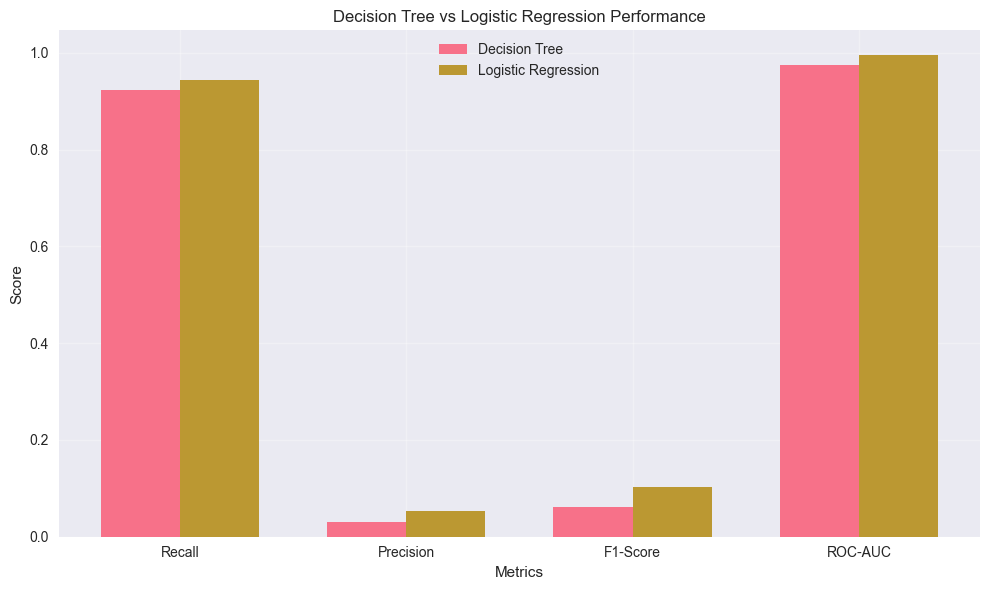

In [17]:
# STEP 14: Compare with Logistic Regression
print("\n14. Comparison with Logistic Regression...")

# Load logistic regression results for comparison
try:
    lr_performance = pd.read_csv('reports/logistic_regression_performance.csv').iloc[0]
    
    comparison = pd.DataFrame({
        'Metric': ['Recall', 'Precision', 'F1-Score', 'ROC-AUC', 'Avg Precision'],
        'Decision Tree': [recall, precision, f1, roc_auc, avg_precision],
        'Logistic Regression': [lr_performance['recall'], lr_performance['precision'], 
                              lr_performance['f1_score'], lr_performance['roc_auc'], 
                              lr_performance['avg_precision']]
    })
    
    print("\nModel Comparison:")
    print("=" * 50)
    print(comparison.round(4))
    
    # Visual comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    metrics = ['Recall', 'Precision', 'F1-Score', 'ROC-AUC']
    x = np.arange(len(metrics))
    width = 0.35
    
    ax.bar(x - width/2, comparison.loc[:3, 'Decision Tree'], width, label='Decision Tree')
    ax.bar(x + width/2, comparison.loc[:3, 'Logistic Regression'], width, label='Logistic Regression')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Decision Tree vs Logistic Regression Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("⚠ Logistic Regression results not found for comparison")


In [18]:
# STEP 15: Final Summary
print("\n" + "="*50)
print("FINAL SUMMARY - DECISION TREE")
print("="*50)

print(f"\nMODEL PERFORMANCE:")
print(f"• Recall (Frauds Caught): {recall:.1%}")
print(f"• Precision (Accuracy of Fraud Alerts): {precision:.1%}")
print(f"• F1-Score: {f1:.4f}")
print(f"• ROC-AUC: {roc_auc:.4f}")

print(f"\nBUSINESS IMPACT:")
frauds_caught = cm[1, 1]  # True Positives
frauds_missed = cm[1, 0]  # False Negatives
false_alarms = cm[0, 1]   # False Positives

print(f"• Frauds detected: {frauds_caught}/{frauds_caught + frauds_missed} ({recall:.1%})")
print(f"• False alarms: {false_alarms} legitimate transactions flagged")
print(f"• Optimal threshold: {optimal_threshold:.2f}")

print(f"\nTREE CHARACTERISTICS:")
print(f"• Tree Depth: {best_dt.get_depth()}")
print(f"• Number of Leaves: {best_dt.get_n_leaves()}")
print(f"• Most important feature: {feature_importance.iloc[0]['feature']}")

print(f"\nKEY INSIGHTS:")
top_3_features = feature_importance.head(3)['feature'].tolist()
print(f"• Top fraud indicators: {', '.join(top_3_features)}")
print(f"• Decision rules are interpretable and explainable")
print(f"• Model complexity controlled via hyperparameter tuning")

print(f"\nDecision Tree implementation completed successfully!")


FINAL SUMMARY - DECISION TREE

MODEL PERFORMANCE:
• Recall (Frauds Caught): 92.2%
• Precision (Accuracy of Fraud Alerts): 3.1%
• F1-Score: 0.0607
• ROC-AUC: 0.9747

BUSINESS IMPACT:
• Frauds detected: 83/90 (92.2%)
• False alarms: 2563 legitimate transactions flagged
• Optimal threshold: 0.70

TREE CHARACTERISTICS:
• Tree Depth: 3
• Number of Leaves: 8
• Most important feature: V14

KEY INSIGHTS:
• Top fraud indicators: V14, V4, V10
• Decision rules are interpretable and explainable
• Model complexity controlled via hyperparameter tuning

Decision Tree implementation completed successfully!
